<a href="https://colab.research.google.com/github/danielsabino/ppgti3007_cv_2021_2/blob/main/semana03/aula05/%5Bnotebook%5Dcv_w03_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteção de objetos

Classificar uma imagem entre várias possíveis categorias utilizando aprendizado de máquina é uma tarefa interessante. No entanto, classificar uma imagem não nos permite entender individualmente os elementos que compõem essa imagem. 

Identificar objetos dentro de um cenário é uma tarefa simples para humanos, mas para máquinas essa tarefa não é trivial. Um **detector de objetos** deve ser capaz de identificar a presença de um determinado elemento de interesse dentro da imagem não importando sua localização ou tamanho.

Dentro desse contexto, a palavra *objeto* é utilizada para descrever qualquer coisa que se queira identificar dentro de uma imagem: carro, pessoa, rosto, bola, etc. Qualquer coisa que possua uma estrutura minimamente consistente pode ser categorizada como um objeto a ser identificado.

Considerando que no mundo real, os objetos podem conter variações de formato, que as condições de iluminação são muito diferentes entre capturas e que existem todas aquelas dificuldades já apontadas na tarefa de classificação de imagens, a detecção de objetos se torna uma tarefa bastante complexa para a máquina executar.

Uma vez dominados os conceitos capazes de tornar essa tarefa complexa possível, podemos utilizar a deteção de objetos para incontáveis aplicações úteis: encontrar pessoas, contar veículos, encontrar vagas em estacionamentos, realizar buscas visuais, detectar ameaças, entre muitas outras coisas.

Existem várias maneiras que existem para realizar a detecção de objetos em imagens. A mais rudimentar é a de *template matching*, que basicamente compara pixel a pixel a imagem de um objeto de interesse (*template*) com a imagem onde se quer buscar. Com poucas exceções, essa técnica não é eficiente para detectar objetos.

Por outro lado, as técnicas mais recentes baseadas em *deep learning* são capazes de encontrar objetos nas situações mais complexas existentes. 

No contexto deste curso, como queremos explorar a maneira como as coisas são feitas, vamos inicialmente implementar um detector de objetos simples que faz uso da técnica de janelas deslizantes e, só depois, passamos para técnicas baseadas em *deep learning*.

Neste notebook, vamos realizar a detecção por meio da técnica de janelas deslizantes extraíndo *manualmente* as características das imagens. A seguir, esse pipeline de processos é detalhado.

# Pipeline de Detecção de Objetos

De uma maneira geral, os passos para montar um método simples (mas robusto) de deteção de objetos consiste em cinco passos:

1. Preparar os dados e experimentos
2. Extrair as caraterísticas
3. Treinamento do classificador
4. Obter o *bounding box* final
5. *hard negative mining*
6. Retreinamento

Vamos passar por cada um desses passos a seguir.

## Preparar os dados e experimentos

Para iniciar os experimentos, precisamos construir a nossa base de dados. Vamos utilizar como exemplo a base CALTECH-101 (http://www.vision.caltech.edu/Image_Datasets/Caltech101/).

Essa base de dados contém 101 objetos diferentes com um conjunto de 40 a 800 imagens por categoria. Obviamente, vamos escolher uma das classes para trabalhar no nosso detector. A classe escolhida inicialmente é a `car_side`, que contém imagens de carros (imagens laterais).

Sabendo que a base do detector de objetos é um classificador, precisamos de exemplos do que são esses objetos e exemplos do que não consiste no objeto de interesse. Daqui em diante, vamos chamar esses exemplos de positivos (objeto de interesse) e negativos (outros objetos). Para a base de imagens negativas, vamos utilizar a 13 Natural Scene Category (http://vision.stanford.edu/resources_links.html#datasets).

Além das imagens contendo o objeto, precisamos da informação de localização de tal objeto dentro delas. Normalmente, essa informação é representada por um *bouding box*, ou seja, um retângulo que contorna todo o objeto. A forma de armazenar os dados do *bounding box* variam, mas é comum guardar a posição $(x,y)$ do canto superior esquerdo juntamente com a largura e altura do retângulo. A partir desses quatro dados é possível extrair somente o objeto de interesse da imagem.

Vamos iniciar obtendo os conjuntos de dados.

In [1]:
# criar diretorio para guardar dados
!mkdir '/content/data/'

In [2]:
# download da base Caltech
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp" -O '/content/data/caltech101.tar.gz' && rm -rf /tmp/cookies.txt

--2022-02-19 18:50:28--  https://docs.google.com/uc?export=download&confirm=t&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
Resolving docs.google.com (docs.google.com)... 142.250.152.139, 142.250.152.113, 142.250.152.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jlvlq89tj2lalbl45crtdllrklt4p6ug/1645296600000/15424859768005087218/*/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp?e=download [following]
--2022-02-19 18:50:28--  https://doc-00-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jlvlq89tj2lalbl45crtdllrklt4p6ug/1645296600000/15424859768005087218/*/137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp?e=download
Resolving doc-00-24-docs.googleusercontent.com (doc-00-24-docs.googleusercontent.com)... 173.194.196.132, 2607:f8b0:4001:c1a::84
Connecting to doc-00-24-docs.googleusercontent.com (doc-

In [3]:
# download das anotações das imagens da base caltech
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m' -O '/content/data/caltech_annotations.tar'

--2022-02-19 18:50:31--  https://docs.google.com/uc?export=download&id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
Resolving docs.google.com (docs.google.com)... 142.250.152.139, 142.250.152.138, 142.250.152.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2i18ao5165vl3rt2u4nq366uqp66qej6/1645296600000/15424859768005087218/*/175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m?e=download [following]
--2022-02-19 18:50:41--  https://doc-00-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2i18ao5165vl3rt2u4nq366uqp66qej6/1645296600000/15424859768005087218/*/175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m?e=download
Resolving doc-00-24-docs.googleusercontent.com (doc-00-24-docs.googleusercontent.com)... 142.250.152.132, 2607:f8b0:4001:c1a::84
Connecting to doc-00-24-docs.googleusercontent.com (doc-00-24-docs

In [4]:
# criando subdiretorio e descompactando a base caltech
!mkdir '/content/data/caltech'
!tar -xzvf '/content/data/caltech101.tar.gz' -C '/content/data/caltech/'

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chai

In [5]:
# descompactando as anotações base caltech
!tar -xvf '/content/data/caltech_annotations.tar' -C '/content/data/caltech/'

Streaming output truncated to the last 5000 lines.
Annotations/chair/annotation_0002.mat
Annotations/chair/annotation_0003.mat
Annotations/chair/annotation_0004.mat
Annotations/chair/annotation_0005.mat
Annotations/chair/annotation_0006.mat
Annotations/chair/annotation_0007.mat
Annotations/chair/annotation_0008.mat
Annotations/chair/annotation_0009.mat
Annotations/chair/annotation_0010.mat
Annotations/chair/annotation_0011.mat
Annotations/chair/annotation_0012.mat
Annotations/chair/annotation_0013.mat
Annotations/chair/annotation_0014.mat
Annotations/chair/annotation_0015.mat
Annotations/chair/annotation_0016.mat
Annotations/chair/annotation_0017.mat
Annotations/chair/annotation_0018.mat
Annotations/chair/annotation_0019.mat
Annotations/chair/annotation_0020.mat
Annotations/chair/annotation_0021.mat
Annotations/chair/annotation_0022.mat
Annotations/chair/annotation_0023.mat
Annotations/chair/annotation_0024.mat
Annotations/chair/annotation_0025.mat
Annotations/chair/annotation_0026.mat

In [6]:
# download da base SceneClass13
!wget 'http://vision.stanford.edu/Datasets/SceneClass13.rar' -P 'data/'

--2022-02-19 18:50:58--  http://vision.stanford.edu/Datasets/SceneClass13.rar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58189776 (55M) [text/plain]
Saving to: ‘data/SceneClass13.rar’

SceneClass13.rar    100%[===================>]  55.49M  19.3MB/s    in 2.9s    

2022-02-19 18:51:01 (19.3 MB/s) - ‘data/SceneClass13.rar’ saved [58189776/58189776]



A classe `sceneclass13` foi escolhida porque não deve conter imagens de carros nela. Inclusive, isso é muito importante: as imagens da classe negativa não devem conter o objeto de interesse dentro delas.

In [7]:
# instalando rar para descompactar base de dados 
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1


In [8]:
!rar x -Y "/content/data/SceneClass13.rar" "/content/data/SceneClass13/"


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help


Extracting from /content/data/SceneClass13.rar

Creating    /content/data/SceneClass13                                OK
Creating    /content/data/SceneClass13/livingroom                     OK
Extracting  /content/data/SceneClass13/livingroom/image_0001.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livingroom/image_0002.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livingroom/image_0003.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livingroom/image_0004.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livingroom/image_0005.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livingroom/image_0006.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livingroom/image_0007.jpg           0%  OK 
Extracting  /content/data/SceneClass13/livin

In [9]:
conf = {
# caminho para a base de imagens do objeto de interesse
'image_dataset': 'data/caltech/101_ObjectCategories/car_side',
# caminho para as informações de bounding boxes
'image_annotations': 'data/caltech/Annotations/car_side',
# caminho para imagens da classe negativa
'image_distractions': 'data/SceneClass13'
}

### Explorando os dados

Uma prática interessante antes de fazer qualquer coisa é explorar os dados buscando entender suas principais caraterísticas e como isso pode ser utilizado na configuração do seu experimento.

Vamos iniciar mostrando um exemplo de imagem e como o bounding box pode ser utilizado para extrair a região de interesse da imagem (*region of interest* - ROI).

In [10]:
# pacotes necessário
import numpy as np
import glob
from scipy import io
import cv2
from google.colab.patches import cv2_imshow

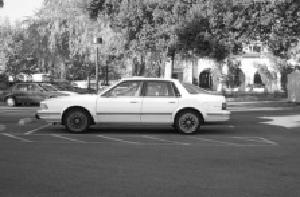

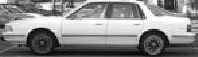

In [11]:
# carrega uma imagem de exemplo
image = cv2.imread('/content/data/caltech/101_ObjectCategories/car_side/image_0001.jpg')
# carrega as anotações sobre essa mesma imagem
bb = io.loadmat('/content/data/caltech/Annotations/car_side/annotation_0001.mat')
# mostra imagem original
cv2_imshow(image)

# extraindo as informações de bounding box do carro
(y, h, x, w) = bb['box_coord'][0]
# pegando somente a porção da imagem que contem o carro.
crop = image[y:h, x:w]
# exibindo o recorte do objeto de interese (carro)
cv2_imshow(crop)


De posse das imagens, podemos fazer uma exploração sobre seus metadados. Vamos, por exemplo, analisar o tamanho (largura e altura) médio dos objetos e seu *aspect ratio* médio.



In [12]:
widths = []
heights = []

# loop pelos arquivos de anotação (metadados)
for p in glob.glob(conf["image_annotations"] + "/*.mat"):
	# carrega o bound box associado com a imagem e atualiza a informação de tamanho
	(y, h, x, w) = io.loadmat(p)["box_coord"][0]
	widths.append(w - x)
	heights.append(h - y)

# calcula o valor médio das medidas de interesse.
(avgWidth, avgHeight) = (np.mean(widths), np.mean(heights))
print("[INFO] largura média: {:.2f}".format(avgWidth))
print("[INFO] altura média: {:.2f}".format(avgHeight))
print("[INFO] aspect ratio: {:.2f}".format(avgWidth / avgHeight))

[INFO] largura média: 184.46
[INFO] altura média: 62.01
[INFO] aspect ratio: 2.97


Note que os carros possuem largura média de 184 pixels e altura de 62 pixels. A relação entre largura e altura é de quase 3:1. De posse dessa informação, podemos melhor definir o formato do próximo passo do pipeline.



Antes disso, podemos ainda construir uma função que nos ajudará a extrair a região de interesse da imagem (aquela dentro do *bounding box*).

In [13]:
def crop_ct101_bb(image, bb, padding=10, dstSize=(32, 32)):
	# com base no bounding box extrai o ROI da imagem

	# obtem as coordenadas do canto superior esquerdo, largura e altura
	(y, h, x, w) = bb
	# ajusta o valor de (x,y) considerando um padding
	(x, y) = (max(x - padding, 0), max(y - padding, 0))
	# extrai somente a porção de interesse da imagem
	roi = image[y:h + padding, x:w + padding]
	# redimensiona a região de interesse para um tamanho desejado, se for o caso.
	roi = cv2.resize(roi, dstSize, interpolation=cv2.INTER_AREA)
	# retorna somente a região de interesse da imagem.
	return roi

Note que a função recebe dois parâmetros além da imagem e das coordenadas do *bounding box*: o `padding` que é a adição de alguns pixels a mais nas margens da imagem e `dstSize` que é o tamanho que a imagem recortada deve ser redimensionada. Em geral, esse tamanho é fixo para que a base de imagens possa ser utilizada por algoritmos de aprendizado de máquina.

## Extração de Características

Já sabemos que tratar a imagem a partir da intensidade dos pixels não costuma ser uma boa estratégia. A representação da imagem a partir de características extraídas dela costuma ser muito mais eficiente.

Para realizar a detecção de objetos, essa etapa é extremamente importante e determinante para o sucesso da aplicação. 

Como já foi explicado anteriormente, as características (*features*) são extraídas através de descritores (https://en.wikipedia.org/wiki/Visual_descriptor). Existem muitos desses descritores, mas vamos focar em um que é bastante utilizado na Visão Computacional: o *Histogram of Oriented Gradients (HOG)* - já abordado antes [aqui](https://github.com/danielsabino/ppgti3007_cv_2021_2/blob/main/semana02/aula04/%5Bnotebook%5Dcv_w02_04.ipynb).

### HOG descriptors

Para lembrar, os *histogram of oriented gradients* (https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) são descritores amplamente utilizados na área de Visão Computacional e Processamento Digital de Imagens, sobretudo na tarefa de deteção de objetos.

A técnica consiste, basicamente, em contar a ocorrência de orientação de gradientes em determinadas porções da imagem. O pressuposto básico da técnica está na ideia que é o formato e aparência de um objeto dentro da imagem podem ser descritos pela distribuição de intensidade da orientação dos gradientes ou das bordas (*edges*).

A partir dessa ideia, a imagem é dividida em partes (normalmente, em formato de grade) chamadas de células. Dentro de cada célula, os histogramas de gradientes são computados. A descrição completa da imagem é formada partir da concatenação dos histogramas de todas as células.

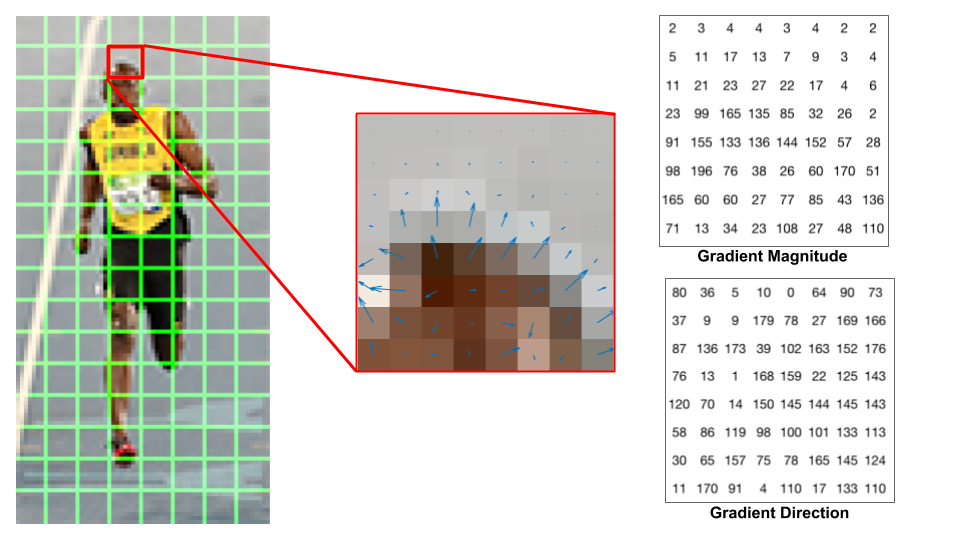


Fonte: https://learnopencv.com/histogram-of-oriented-gradients/

Do ponto de vista de características, já temos como descrever uma imagem. No entanto, para a tarefa de deteção de objetos, não estamos interessado na imagem completa, mas em uma parte de interesse dentro dela. Daí, surge a pergunta: como encontrar o objeto dentro da imagem?

Para compreender melhor isso, devemos utilizar dois princípios básicos que são utilizados: o de pirâmide de imagens e o de janelas deslizantes.

Esses conceitos serão explicados mais a frente, mas o objetivo principal é realizar metodologicamente uma busca dentro da imagem por porções que se pareçam com o objeto de interesse. Como sabemos que objetos podem ter escalas e localizações distintas em imagens diferentes, devemos ter uma estratégia para conseguir capturar essa variação em nosso sistema.

### Pirâmide de Imagens

Para encontrar um objeto específico dentro de uma imagem, precisamos "varrer" essa imagem em busca do objeto. Essa varredura é feita por meio de uma "janela" que desliza sobre a imagem e a cada local verifica se o objeto está ali ou não. O conceito de janelas deslizantes será dado mais a frente.

Antes disso, temos que entender que objetos e imagens podem (e vão) possuir tamanhos diferentes. Temos duas possibilidades, então, para encontrar objetos dadas essas características:

1. definir tamanhos diferentes de janelas para cada situação;
2. fixar o tamanho das janelas, mas utilizar diferentes escalas da imagem.

Essa segunda opção é a mais utilizada porque reduz significativamente a complexidade do problema. Basta que seja definido um tamanho fixo da janela, mas que ela seja aplicada na imagem em diferentes tamanhos. O conjunto da mesma imagem consistentemente mudando de escala é o que chamamos de pirâmide. Veja abaixo um exemplo de uma pirâmide de imagens:

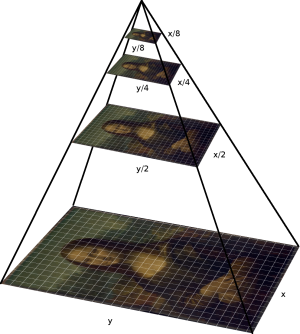

Fonte da imagem: https://customers.pyimagesearch.com/wp-content/uploads/2015/06/brisk_pyramid_example.png

Na base da pirâmide, temos a imagem em seu tamanho original. A medida que subimos, vemos versões da imagem redimensionadas. Esse conceito em conjunto com o de janela deslizantes (a seguir) permite que objetos sejam encontrados em diferentes tamanhos e localizações.

A implementação de uma função que constroi essa pirâmide é relativamente simples. Vamos mostrar a seguir:

In [14]:
# função que redimensiona uma imagem
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
	
  # inicializa as dimensões da imagem e obtém o tamanho da imagem original.
	dim = None
	(h, w) = image.shape[:2]
	# se ambas a altura e largura forem None, retorna a imagem original.  
	if width is None and height is None:
		return image
	
    # calcula o AR com base na altura.
	if width is None:		
		r = height / float(h)
		dim = (int(w * r), height)
	# caso contrário, calcula o AR com base na largura.
	else:
		r = width / float(w)
		dim = (width, int(h * r))
	
  # redimensiona a imagem.
	resized = cv2.resize(image, dim, interpolation=inter)
	
  # retorna a imagem redimensionada.
	return resized

In [15]:
# função que constroi a pirâmide
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# retorna a imagem original
	yield image
	
  # continua o loop pela pirâmide
	while True:
		# computa as novas dimensões da imagem e a redimensiona    
		w = int(image.shape[1] / scale)
		image = resize(image, width=w)
		
    # verifica se o tamanho da imagem redimensinada atinge o tamanho
    # mínimo fornecido. 
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
      # para a construção da pirâmide
			break
		
    # retorna a próxima imagem da pirâmide
		yield image

A função definida possui três argumentos:
1. a imagem original
2. o fator de redimensionamento a cada iteração
3. o tamanho mínimo da imagem (topo da pirâmide)

A função utiliza a instrução `yield` que retorna um elemento `generator`, ou seja, ele é gerado dinamicamente cada vez que a função é chamada. Com o uso desse tipo de instrução, não precisamos alocar memória para toda a pirâmide, mas construir cada "andar" dela dinamicamente de acordo com a necessidade.

Vamos testar a função...

--2022-02-19 18:51:37--  https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana03/aula05/data/yoshi.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34324 (34K) [image/jpeg]
Saving to: ‘/content/data/yoshi.jpg’

/content/data/yoshi 100%[===================>]  33.52K  --.-KB/s    in 0.002s  

2022-02-19 18:51:38 (14.4 MB/s) - ‘/content/data/yoshi.jpg’ saved [34324/34324]



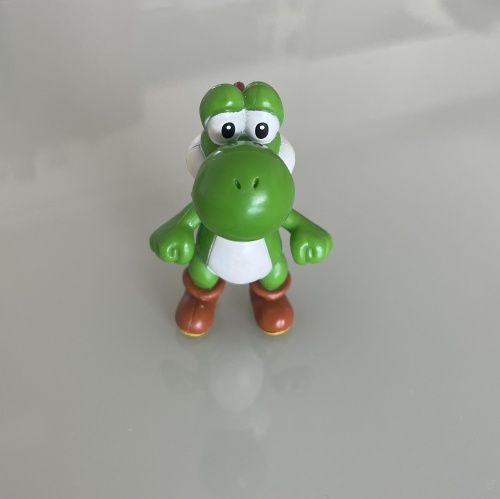

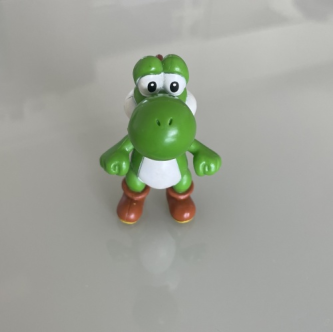

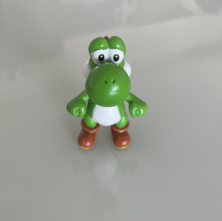

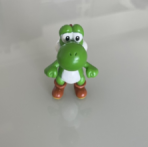

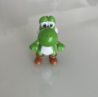

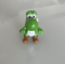

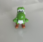

In [16]:
!wget 'https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana03/aula05/data/yoshi.jpg' -O '/content/data/yoshi.jpg'
image = cv2.imread('data/yoshi.jpg')

# loop nas camadas da pirâmide
for (i, layer) in enumerate(pyramid(image, scale=1.5)):
	cv2_imshow(layer)

### Janelas Deslizantes

Para detectar um objeto, precisamos buscar dentro da imagem por esse objeto. A maneira mais simples de fazer isso é sistematizar um processo de varredura de toda (ou quase toda) a imagem.

É através do uso de janelas deslizantes juntamente dentro do contexto da pirâmide de imagens que conseguimos analisar cada uma das regiões das várias variações (escalas) da imagem. 

A seguir, podemos ver como funciona esse conceito implementado.

In [17]:
def sliding_window(image, stepSize, windowSize):
	# move a janela através da imagem
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# retorna a porção da imagem referente a janela corrente
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

Essa função recebe uma imagem e percorre uma janela de tamanho fixo no sentido esquerda para direita e cima para baixo. A cada iteração, ela retorna o recorte daquele trecho da imagem.

Podemos ver essa excução um pouco mais clara se desenharmos um retângulo ao percorrer a imagem. 

*PS: esse tipo de exibição é muito ruim no Google Colab... se alguém souber uma maneira melhor de exibir, estou aceitando sugestões.*

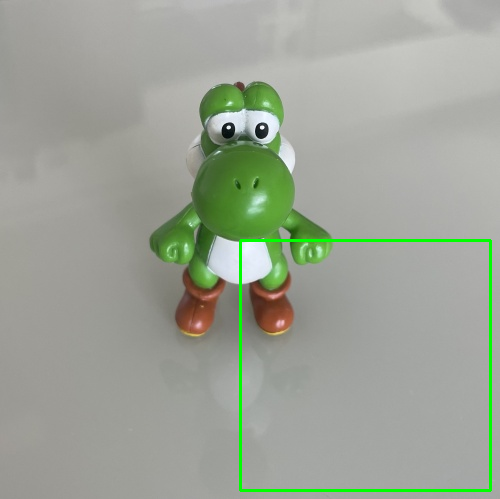

In [18]:
import time
from IPython.display import clear_output

image = cv2.imread('data/yoshi.jpg')
# tamanho da janela
winW = winH = 250
for (x, y, window) in sliding_window(image, stepSize=30, windowSize=(winW, winH)): 

  # se o tamanho do recorte é menor que tamanho definido para a janela, ignore
  if window.shape[0] != winH or window.shape[1] != winW:
    continue

  clone = image.copy()
  # desenha o retângulo

  cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
  cv2_imshow(clone)
  time.sleep(0.25)
  clear_output(wait=True)  

As duas funções (`pyramid` e `sliding_window`) em conjunto formam a base da busca por objetos dentro de uma imagem.

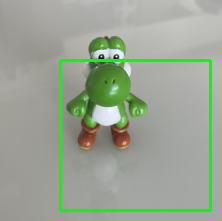

In [19]:
winW = winH = 150
stepSize = 30

# loop em cada imagem da pirâmide
for layer in pyramid(image, scale=1.5):
  # loop das janelas dentro da imagem
  for (x, y, window) in sliding_window(layer, stepSize=stepSize, windowSize=(winW, winH)):
    # se o tamanho do recorte é menor que tamanho definido para a janela, ignore
    if window.shape[0] != winH or window.shape[1] != winW:
      continue

    clone = layer.copy()
    cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
    cv2_imshow(clone)
    time.sleep(0.25)
    clear_output(wait=True)

É muito fundamental notar a importância da pirâmide de imagens e da escolha do tamanho da janela deslizante. O uso multi escalar da imagem permite que um objeto seja detectado em uma escala mesmo que ele não adeque a janela em outra escala.

### Extraindo Características

De posse das funções que constroem a pirâmide de imagens, precisamos agora pensar em como extrair as características de cada uma dessas janelas. Como já foi mencionado antes, não temos interesse em extrair as características da imagem toda, mas de porções dela onde o objeto de interesse possa estar.

Na prática, o que precisamos fazer é percorrer toda as imagens da pirâmide usando as janelas deslizantes e extrair as características de cada uma das janelas. 

De posse dessas características, podemos construir um classificador por meio de aprendizado de máquina que é capaz de nos indicar se um objeto está ou não presente naquela porção da imagem.

Como é de se imaginar, vamos utilizar o descritor HOG para extrair as *features* da imagem

Antes de simplesmente extrair as características, devemos parar para pensar em alguns parâmetros. O primeiro deles é o tamanho da janela deslizante, já que uma escolha errada pode fazer com que objetos não sejam detectados. Se for muito grande, é bem mais difícil conseguir isolar um objeto na cena. Se for muito pequena, o processo pode se tornar inviavelmente custoso.

Além disso, o próprio descritor HOG possui parâmetros referentes a sua divisão interna da imagem em células. Os principais parâmetros do descritor são `pixels_per_cell` e `cells_per_block`. Como o descritor vai extrair característica dentro das janelas, é importante que o tamanho da janela seja divisível por esses parâmetros.

Dentro da visão computacional e aprendizado de máquina o ajuste fino de parâmetros é algo que costuma levar um tempo para fazer e com a experiência isso se torna um pouco menos tedioso. Temos algums pistas iniciais: o tamanho dos *bounding box* dos carros possuem média de largura de 184px e média de altura de 62px. Dessa forma, podemos iniciar com um tamanho menor que esse para garantir que seja possível capturar carros com tamanho menor. Além disso, a proporção largura x altura era de quase 3 para 1.

Dessa forma, para facilitar o andamento da compreensão do processo, vamos definir alguns parâmetros da seguinte maneira:

* tamanho da janela deslizante: largura de 96px e altura de 32px (próximo a metade do tamanho original médio).
* pixels_per_cell = (4, 4)  
* cells_per_block = (2, 2)

Esses dois últimos valores são decorrentes de experimentação prévia que indicaram ser mais interessantes. 

Para extrair as características de cada recorte feito pelas janelas deslizantes, precisamos, primeiro, estruturar os dados de uma maneira que possam ser facilmente acessados e armazenados.

Vamos criar duas funções iniciais para ajudar nisso.

In [20]:
import numpy as np
import h5py

def dump_dataset(data, labels, path, datasetName, writeMethod="w"):
  # abre banco de dados
  db = h5py.File(path, writeMethod)
  # cria um dataset com tamanho compatível
  dataset = db.create_dataset(datasetName, (len(data), len(data[0]) + 1), dtype="float")
  # escreve os dados e rótulos concatenando esses valores
  dataset[0:len(data)] = np.c_[labels, data]
  db.close()
 
def load_dataset(path, datasetName):
  # abre o banco de dados, coleta os dados e rótulos.
  db = h5py.File(path, "r")
  # carrega os dados em duas estruturas separadas
  (labels, data) = (db[datasetName][:, 0], db[datasetName][:, 1:])
  db.close()
  # retorna a tupla de dados e rótulos
  return (data, labels)

Para o momento, vamos utilizar o sistema HDF5 para armazenar os dados em disco. Qualquer banco de dados poderia ser utilizado para realizar essa tarefa. Na verdade, não seria necessário um banco de dados para realizar a tarefa (tudo poderia ficar na memória), mas para já ganhar experiência com esse tipo de estrutura, estamos incluindo no *pipeline*.

Nas funções, temos os seguintes parâmetros:

* data: lista de *feature vectors* a serem armazenados.
* labels: lista de rótulos associados aos *feature vectors*.
* path: caminho onde o banco de dados vai ficar alocado no disco.
* datasetName: nome do conjunto de dados
* writeMethod: indica o tipo de abertura da base de dados ('w' - escrita; 'a' - append; 'r' - leitura).

Vamos, então, juntar tudo para extrair as características das imagens.

In [21]:
from imutils import paths
import progressbar
import skimage
from skimage import feature
import random

# parâmetro referente ao percentual de utilização da base para treinamento
conf['percent_gt_images'] = 0.5
# tamanho do padding (quantidade de pixels) a ser utilizado no corte da imagem
# é sempre bom deixar uns pixels a mais nas bordas da imagem
conf['offset'] = 5
# tamanho da janela deslizante
conf['window_dim'] = [96, 32]
# número de orientações do descritor HOG
conf['orientations'] = 9
# pixels por célula do HOG
conf['pixels_per_cell'] = [4, 4]
# células por bloco do HOG
conf['cells_per_block'] = [2, 2]

data = []
labels = []

# obtém um conjunto de referência para o treinamento
trnPaths = list(paths.list_images(conf["image_dataset"]))
trnPaths = random.sample(trnPaths, int(len(trnPaths) * conf["percent_gt_images"]))
print("[INFO] describing training ROIs...")

[INFO] describing training ROIs...


In [22]:
print(f'Tamanho do conjunto de treinamento: {len(trnPaths)}')

Tamanho do conjunto de treinamento: 61


Até esse momento, fizemos só inicializar algumas variáveis a serem utilizadas mais a frente.

In [23]:
# cria um elemento de progress bar só para acompanhar a evolução do processo.
widgets = ["Extraindo: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()
# loop nos caminhos de arquivos de treinamento
for (i, trnPath) in enumerate(trnPaths):
  image = cv2.imread(trnPath)
  # converte para escala de cinza
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # define um ID para a imagem baseada no nome dela.
  imageID = trnPath[trnPath.rfind("_") + 1:].replace(".jpg", "")
  # carrega a anotação (bounding box) da imagem
  p = f"{conf['image_annotations']}/annotation_{imageID}.mat"
  bb = io.loadmat(p)["box_coord"][0]
  # extrai o ROI da imagem (corta só o objeto de interesse) usando a função definida
  # antes.
  roi = crop_ct101_bb(image, bb, padding=conf["offset"], dstSize=tuple(conf["window_dim"]))

  # realiza o flip na imagem para aumentar a quantidade de dados disponíveis.
  rois = (roi, cv2.flip(roi, 1))

  # loop em cada ROI
  for roi in rois:
    # extrai as características do ROI e atualiza a lista de features e rótulos
    features = feature.hog(roi, conf['orientations'], pixels_per_cell=conf['pixels_per_cell'],
        cells_per_block=conf['cells_per_block'], transform_sqrt=True)
    data.append(features)
    labels.append(1)
  # atualiza a barra de progresso
  pbar.update(i)
pbar.finish()

Extraindo: 100% |##############################################| Time:  0:00:00


Nesse processo é possível notar que fizemos algumas coisas a mais. A primeira delas foi já separar uma parte dos dados para treinamento e extrair as características somente delas. Esse percentual ficou em 50% para o nosso estudo de caso. 

A segunda foi realizar uma operação de *flip* nas imagens. Note que isso é fundamental para conseguir ampliar o conjunto de dados e adicionar perspectiva para a base de dados. Na aplicação de carros, esse tipo de operação ajuda bastante, já que adiciona uma imagem de carros em direções opostas. Veja a seguir um exemplo dessa operação.

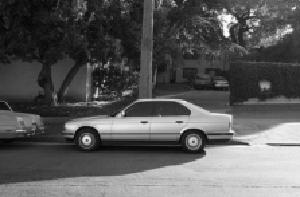

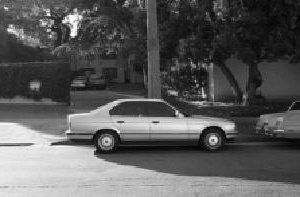

In [24]:
image = cv2.imread(list(paths.list_images(conf["image_dataset"]))[0])
cv2_imshow(image)
cv2_imshow(cv2.flip(image,1))

Uma vez tratado todo o conjunto de exemplos positivos da nossa base de dados, precisamos extrair as características das imagens negativas.

In [25]:
from sklearn.feature_extraction.image import extract_patches_2d

# define o número de imagens negativas a serem utilizadas
conf['num_distraction_images'] = 500
# define o número de pedaços da imagem negativa que deve ser extraído
conf['num_distractions_per_image'] = 10

# pega as imagens negativas
dstPaths = list(paths.list_images(conf['image_distractions']))
widgets = ["Extraindo: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=conf["num_distraction_images"], widgets=widgets).start()
# loop em uma quantidade de imagens negativas
for i in np.arange(0, conf['num_distraction_images']):
  # aleatoriamente seleciona uma imagem do conjunto negativo
  image = cv2.imread(random.choice(dstPaths))
  # converte para escala de cinza
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # extrai pedaços aleatórios da imagem
  patches = extract_patches_2d(image, tuple(conf["window_dim"]),
    max_patches=conf["num_distractions_per_image"])
  # loop em cada pedaço
  for patch in patches:
    # extrai as características do pedaço e atualiza a lista de dados e rótulos.
    features = feature.hog(patch, conf['orientations'], pixels_per_cell=conf['pixels_per_cell'],
        cells_per_block=conf['cells_per_block'], transform_sqrt=True)
    data.append(features)
    labels.append(-1)
  # atualiza a barra de progresso
  pbar.update(i)
pbar.finish()

Extraindo: 100% |##############################################| Time:  0:00:29


A última coisa a fazer é colocar todas as *features* extraídas no banco de dados construído.

In [26]:
!mkdir '/content/output/'
conf['features_path'] = '/content/output/car_features.hdf5'
print('[INFO] dumping features e rótulos para o arquivo...')
dump_dataset(data, labels, conf['features_path'], 'features')

[INFO] dumping features e rótulos para o arquivo...


## Treinamento

Finalmente, depois de conseguir extrair as características do nosso conjunto de dados, incluindo exemplos positivos e negativos, podemos partir para a deteção em si com um processo de treinamento de classificador que será o responsável por informar se existe ou não o objeto desejado na imagem.

Vamos, então carregar o nosso conjunto de dados a partir do banco criado anteriormente.

In [27]:
print("[INFO] carregando dataset...")
(data, labels) = load_dataset(conf['features_path'], 'features')

[INFO] carregando dataset...


Para nossa tarefa de classificação, vamos escolher a técnica *Support Vector Machine* (SVM) com *kernel* linear. Essa técnica é bastante robusta para encontrar padrões complexos.

As SVMs buscam encontrar o hiperplano de separação ótimo entre as classes e utiliza o recurso de *kernel* para transformar os dados para um espaço de características diferentes (onde é possivelmente mais simples de se separar). Para saber um pouco mais sobre a SVM, pode ir em https://pt.wikipedia.org/wiki/Máquina_de_vetores_de_suporte

In [28]:
from sklearn.svm import SVC
import pickle

# local para armazenar o classificador após treinado
conf['classifier_path'] = '/content/output/classificador.cpickle'

print("[INFO] treinando o classificador...")

model = SVC(kernel="linear", C=0.01, probability=True, random_state=42)
model.fit(data, labels)
# armazenando o classificador no arquivo
print("[INFO] dumping classificador...")
f = open(conf["classifier_path"], "wb")
f.write(pickle.dumps(model))
f.close()

[INFO] treinando o classificador...
[INFO] dumping classificador...


O SVM possui um parâmetro importante a ser configurado, o `C`. Ele diz o quão restrito o SVM é, ou seja, quanto maior esse valor, menos erros o SVM pode cometer. Apesar de interessante, valores altos devem levar a um *overfitting*. Se colocamos valores baixos, deixamos o classificador mais "soft" ao ponto de cometer alguns erros, mas sem causar *overfitting*. Nesses casos, algumas medidas adicionais devem ser tomadas (como o non-maxima supression em seguida).

Seguindo essa linha, ao treinar o classificador, optamos por um valor pequeno para o parâmetro `C = 0.01`. 

Precisamos, para detectar um objeto na imagem, realizar a seguinte sequência de passos:

1. construir a pirâmide de imagens
2. varrer todas as camadas da pirâmida utilizando as janelas deslizantes
3. para cada passo da janela, extrair as características usando o descritor HOG
4. passar as características para o modelo SVM treinado e observar a probabilidade de classificação indicada por ele
5. atribuir a classe positiva todos as janelas que tiverem uma probilidade de classificação maior que um limiar previamente definido
5. armazenar os dados de todas as janelas que receberam uma classificação positiva para detecção de objetos

Todos esses passos são contemplados na função a seguir:

In [29]:
def detect(image, model, winDim, winStep=4, pyramidScale=1.5, minProb=0.7):
# inicializa a lista de bounding boxes e probabilidades associadas
  boxes = []
  probs = []

  # loop na pirâmide de imagens    
  for layer in pyramid(image, scale=pyramidScale, minSize=winDim):
    # determina a escala atual da pirâmide
    scale = image.shape[0] / float(layer.shape[0])
    # loop da janela deslizante em todas as imagens da pirâmide
    for (x, y, window) in sliding_window(layer, winStep, winDim):
      # pega as dimensões da janela
      (winH, winW) = window.shape[:2]
      # garante que as dimensões da janela se enquadram com os valores fornecidas
      # para a janela deslizante      
      if winH == winDim[1] and winW == winDim[0]:
        # extrai as características HOG da janela atual e classifca para determinar
        # se o objeto de interesse está presente ou não.        
        
        features = feature.hog(window, conf['orientations'], pixels_per_cell=conf['pixels_per_cell'],
        cells_per_block=conf['cells_per_block'], transform_sqrt=True).reshape(1, -1)

        #features = desc.describe(window).reshape(1, -1)
        
        # executa a predição do classificador e guarda o resultado em termos de probabilidade
        prob = model.predict_proba(features)[0][1]
        # verifica se o classificador encontrou um objeto com probabilidade suficiente        
        if prob > minProb:
          # calcula a coordenada (x,y) do bounding box usando a escala atual da imagem          
          (startX, startY) = (int(scale * x), int(scale * y))
          endX = int(startX + (scale * winW))
          endY = int(startY + (scale * winH))
          # atualiza a lista de bounding boxes e probabilidades          
          boxes.append((startX, startY, endX, endY))
          probs.append(prob)
  # retorna uma tupla de bounding boxes e probabilidades
  return (boxes, probs)

Vamos colocar tudo para funcionar e testar a deteção.

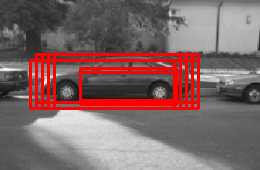

In [30]:
import imutils

# definindo mais um parâmetro para as janelas deslizantes
conf['window_step'] = 4

# definindo a probabilidade mínima para o classificador considerar que existe um
# objeto na imagem
conf['min_probability'] = 0.7

# define a escala da pirâmide de imagens
conf['pyramid_scale'] = 1.5

# carrega o modelo treinado
model = pickle.loads(open(conf['classifier_path'], "rb").read())
# carrega a imagem para testar
image = cv2.imread('/content/data/caltech/101_ObjectCategories/car_side/image_0004.jpg')
# redimensiona a imagem para uma largura padrão
image = imutils.resize(image, width=min(260, image.shape[1]))
# converte para escala de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# detecta objetos na imagem
(boxes, probs) = detect(gray, model, conf["window_dim"], winStep=conf["window_step"],
	pyramidScale=conf["pyramid_scale"], minProb=conf["min_probability"])
# loop nos bounding boxes para desenhá-los
for (startX, startY, endX, endY) in boxes:
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
# mostra a imagem final
cv2_imshow(image)

Note que existem múltiplos *bounding boxes* na imagem, mas somente um carro. Isso quer dizer que o detector não funcionou? Claro que funcionou! Como utilizamos um passo pequeno da janela deslizante, é natural que várias delas contenham um carro dentro. 

Para resolver o problema de múltiplos *bounding boxes* devemos utilizar uma técnica chamada *non-maxima supression*, que será vista a seguir.

## Non-maxima Supression

O objetivo da técnica *non-maxima supression* (NMS) é calcular a taxa de sobreposição entre os *bounding boxes* e remover aqueles que tiverem maior sobreposição.

Sua implementação é relativamente simples, como podemos ver a seguir.



In [31]:
def non_max_suppression(boxes, probs, overlapThresh):
  # se não existem bbs, retornar uma lista vazia
  if len(boxes) == 0:
    return []
  # converte os valores dos bbs para float já que haverá operações de divisão.
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  
  # inicializa uma lista para guardar os bbs selecionados
  pick = []
  # pega as coordenadas dos bbs
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]
  # calcula a área dos bbs e os ordena pela probabilidade associada a cada um.
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(probs)

  # loop pela lista de indices ordenadas
  while len(idxs) > 0:
    # pega o último indice da lista (maior probabilidade) e adiciona a lista de valores selecionados.
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # encontra os maiores valores de (x,y) para ser o início do bounding box e os
    # menores valores (x,y) para ser o fim do bounding box.
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    # calcula a largura e altura do bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    # calcula a taxa de sobreposição
    overlap = (w * h) / area[idxs[:last]]
    # deleta todos os índices que possuem sobreposição maior que limiar
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
  # retorna apenas os bounding boxes selecionados
  return boxes[pick].astype("int")

Para usar essa função, precisamos que todos os *bounding boxes* estejam em um array na forma (x inicial, y inicial, x final, y final). Precisamos também da probabilidade associada a cada *bounding box* obitidas durante o processo de classificação. Existe também um parâmetro associado ao limiar de sobreposição entre os *bounding boxes* a ser considerado.

O que o algoritmo faz nesse momento é selecionar o *bouding box* com maior probabilidade e compará-lo com os demais para verificar a sobreposição. Nos casos onde a sobreposição é maior que um limiar determinado, os *bouding boxex* com menor probabilidade são suprimidos. Ao final do processo, só ficam os *bouding boxes* que possuem altos índices de confiança e que tem pouca sobreposição entre si.

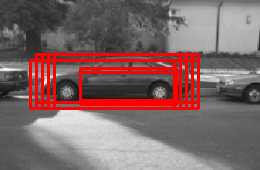

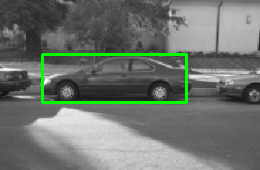

In [32]:
conf['overlap_thresh'] = 0.3

model = pickle.loads(open(conf['classifier_path'], 'rb').read())

image = cv2.imread('/content/data/caltech/101_ObjectCategories/car_side/image_0004.jpg')
image = imutils.resize(image, width=min(260, image.shape[1]))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect objects in the image and apply non-maxima suppression to the bounding boxes
(boxes, probs) = detect(gray, model, conf["window_dim"], winStep=conf["window_step"],
	pyramidScale=conf["pyramid_scale"], minProb=conf["min_probability"])

pick = non_max_suppression(np.array(boxes), probs, conf["overlap_thresh"])
orig = image.copy()

# loop over the original bounding boxes and draw them
for (startX, startY, endX, endY) in boxes:
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)

# loop over the allowed bounding boxes and draw them
for (startX, startY, endX, endY) in pick:
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output images
cv2_imshow(orig)
cv2_imshow(image)

Para mostrar o funcionamento em outras imagens, execute a célula abaixo que seleciona aleatoriamente imagens do diretório e desenha o bounding box do que o classificador entendeu como carro. Cada vez que você executa a célula, uma nova imagem é selecionada aleatoriamente.

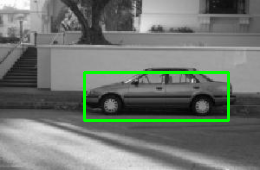

In [35]:
from glob import glob

# lista somente as imagens no diretório
test_images = glob('/content/data/caltech/101_ObjectCategories/car_side/*.jpg')
# obtém o número de imagens no diretório
num_images = len(test_images)
# seleciona aleatoriamente 5 imagens para testar o detector de carros
rand_idx = random.randint(0,num_images-1)

image = cv2.imread(test_images[rand_idx])
image = imutils.resize(image, width=min(260, image.shape[1]))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(boxes, probs) = detect(gray, model, conf["window_dim"], winStep=conf["window_step"],
	pyramidScale=conf["pyramid_scale"], minProb=conf["min_probability"])

pick = non_max_suppression(np.array(boxes), probs, conf["overlap_thresh"])

for (startX, startY, endX, endY) in pick:
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output images
cv2_imshow(image)

# Considerações Finais

Foi mostrado que é possível construir um detector de objetos a partir de elementos relativamente básicos. Os conceitos relacionados à detecção foram expostos na teoria e na prática.

O método utilizado não é o estado da arte, mas definitivamente é útil para demonstrar vários princípios da visão computacional. 

Existem ainda passos posteriores que podem ser adicinados para melhorar a performance do pipeline indicado. Por exemplo, executar o *hard negative mining*, que consiste em verificar onde o algoritmo aponta falsos positivos e incluir na base de negativos como reforço.

In [ ]:
# caso queira executar todo o notebook ou simplesmente limpar seu ambiente de execução
# descomente as linhas abaixo e execute essa célula.

#!rm -rf '/content/data/'
#!rm -rf '/content/output/'